#### LIBRERIAS

In [3]:
#Funciones
import numpy as np
import QuantLib as ql
from tqdm import tqdm 
#for testing
import matplotlib.pyplot as plt
import pandas as pd
import sys, os
import xlwings as xw
import seaborn as sns
   
# data_path = r'Y:\Liquidez\Codigos\xva\jupyter\swap.xlsm'
data_path = r'swap.xlsm'


#Functions
from functions_xva import *
pd.options.display.float_format = '{:,.4f}'.format
np.set_printoptions(precision=4)

#### DATA

* USD_LOCAL corresponde a la curva dolar local.

In [4]:
#sigma
data = pd.read_excel(data_path, usecols='L:AX', skiprows=4,nrows=61,sheet_name='Boost',index_col='Aux')
param = pd.read_excel(data_path, usecols='T:AB',skiprows=4,nrows=1,sheet_name='vol y corr')
data_historica = pd.read_excel(data_path, usecols='A:H', skiprows=4,sheet_name='vol y corr',index_col='Dates')

SIGMA_NOMINAL = param['icp_vol'][0]
SIGMA_REAL = param['real_vol'][0]
SIGMA_INFLACION = param['infla_vol'][0]
SIGMA_TC = param['tc_vol'][0]
SIGMA_LIBOR = param['libor_vol'][0]
SIGMA_USD_LOCAL = param['usd_loc_vol'][0]
SIGMA_OIS = param['ois_vol'][0]

UF_HOY = param['uf_spot'][0]
USD_HOY = param['tc_spot'][0]

In [5]:
print('Volatilidades anuales:')
print('ICP: ', SIGMA_NOMINAL*100)
print('Real: ', SIGMA_REAL*100)
print('Inflacion: ',SIGMA_INFLACION*100) 
print('Dolar: ',SIGMA_TC*100)
print('Libor: ',SIGMA_LIBOR*100)
print('USD Loc: ',SIGMA_USD_LOCAL*100)

print('\nOtros:')
print('UF Hoy: ', UF_HOY)
print('SPOT Hoy: ', USD_HOY)

Volatilidades anuales:
ICP:  1.3228959970367478
Real:  0.9874199369027161
Inflacion:  0.48637957152079925
Dolar:  9.946986357950719
Libor:  0.7677780659696452
USD Loc:  0.7690228668385554

Otros:
UF Hoy:  33504.3
SPOT Hoy:  891.95


#### GLOBAL SETTINGS

In [6]:
TODAY = ql.Settings.instance().evaluationDate
ANOS_SIMULADOS = 20
DIAS_POR_ANO = 250
N_SIM = 100

In [7]:
DT = 1/DIAS_POR_ANO
T = ANOS_SIMULADOS*DIAS_POR_ANO
STEPS = np.arange(1,T+1)*DT

#### CORRELACION Y COVARIANZA

In [8]:
#CALCULO DE RETORNO DEL TIPO DE CAMBIO
data_historica['tc_log_r']= np.log(data_historica.tc).diff()*100
data_historica.drop(columns=['tc'],inplace=True)
data_historica.dropna(inplace=True)

In [9]:
CORR_MATRIX = data_historica.corr()
COV_MATRIX = data_historica.cov()

In [10]:
COV_MATRIX

,icp,ois,usd_loc,libor,inflation,real,tc_log_r
icp,3.3876,0.1489,-0.1111,0.2217,1.2515,1.2074,0.0138
ois,0.1489,0.6724,0.5950,0.6594,0.1918,-0.2279,0.0100
usd_loc,-0.1111,0.5950,0.5915,0.5893,0.0022,-0.2241,0.0077
libor,0.2217,0.6594,0.5893,0.6932,0.1468,-0.1604,0.0057
inflation,1.2515,0.1918,0.0022,0.1468,0.9209,0.1396,0.0090
real,1.2074,-0.2279,-0.2241,-0.1604,0.1396,0.9348,0.0056
tc_log_r,0.0138,0.0100,0.0077,0.0057,0.0090,0.0056,0.4787


#### MOVIMIENTOS BROWNIANOS

In [11]:
W = correlated_BM(COV_MATRIX, STEPS ,n_sim=N_SIM,T=T)

<Figure size 216x144 with 0 Axes>

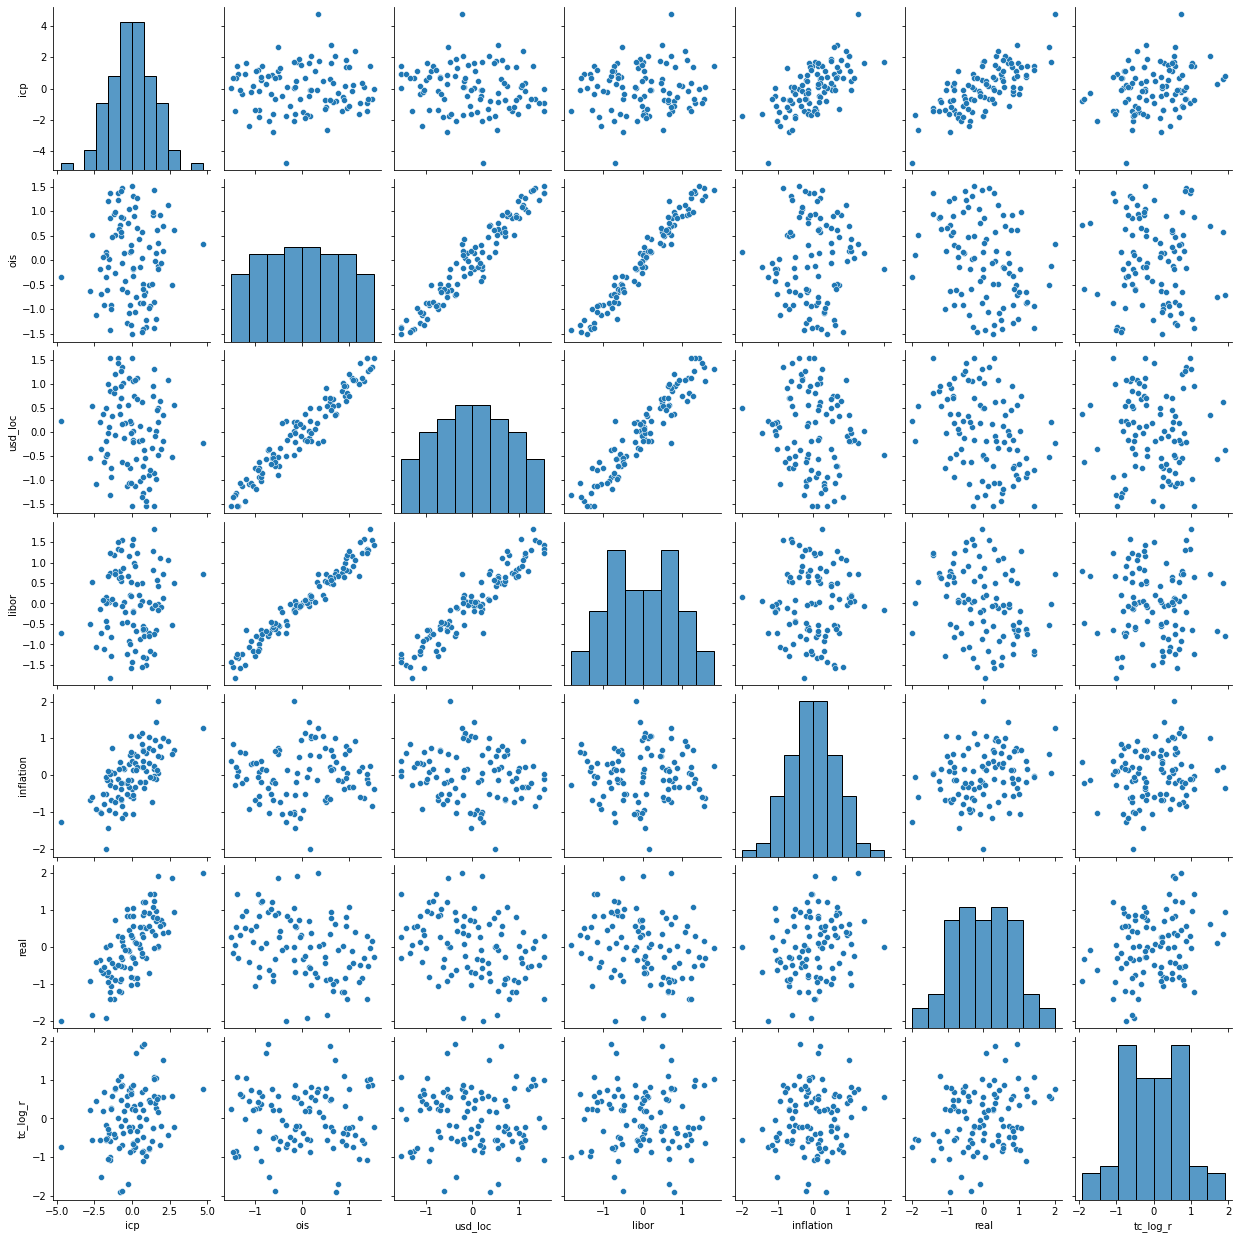

In [12]:
plt.figure(figsize=(3,2))
sns.pairplot(pd.DataFrame(W[1,:,:], columns=COV_MATRIX.columns))
plt.show()

#### CURVAS

#### Curva Nominal

In [13]:
year_fractions = data['YF(360)'].values
discount_nominal = data['DF COLL CLP'].values

#Curva Nominal
dates = [TODAY+int(x) for x in data.Dias.values]
tasas_nominal = (1/discount_nominal-1)/year_fractions

dates.insert(0,TODAY)
tasas_nominal = np.insert(tasas_nominal, 0,0)
curva_nominal = CurvaDescuento(dates, tasas_nominal.tolist(), ql.Actual360())

In [14]:
tasas_nominal*100

array([ 0.    ,  9.7649, 10.7335, 10.3339,  8.3316,  9.8771,  9.2227,
        8.9675,  8.6461,  8.3233,  8.1427,  8.071 ,  8.0253,  7.9929,
        7.9778,  7.9958,  8.0566,  8.139 ,  8.2194,  8.3079,  8.4239,
        8.5594,  8.7069,  8.8604,  9.0264,  9.1943,  9.3755,  9.5613,
        9.7538,  9.9524, 10.1582, 10.3651, 10.5786, 10.7921, 11.0124,
       11.2329, 11.4632, 11.6928, 11.9265, 12.1646, 12.4085, 12.6546,
       12.9096, 13.1658, 13.4319, 13.7014, 13.9834, 14.2621, 14.5575,
       14.8567, 15.1648, 15.4827, 15.8126, 16.1512, 16.5043, 16.8631,
       17.2391, 17.6205, 18.0238, 18.4234, 18.8477, 19.2768])

#### Curva Real

In [15]:
#Curva Zero Real
uf_forward = data['UF Seguro USD'].values
pi = uf_forward/UF_HOY
discount_real = discount_nominal*pi

tasas_real = (1/discount_real-1)*1/year_fractions
tasas_real = np.insert(tasas_real, 0, 0)
tasas_real[1] = tasas_real[2]
curva_real = CurvaDescuento(dates, tasas_real.tolist(), ql.Actual360())

In [16]:
pd.DataFrame({'r':tasas_real[1:]*100,'yf':year_fractions})

,r,yf
0,-0.9753,0.0028
1,-0.9753,0.5167
2,1.2360,1.0139
3,0.2396,1.5278
4,2.4692,2.0333
...,...,...
56,3.3360,28.4083
57,3.4645,28.9250
58,3.5904,29.4222
59,3.7221,29.9361


#### Curva Libor

In [17]:
#Curva Libor
discount_libor = data['DF Libor'].values
tasas_libor = (1/discount_libor[:-1]-1)*1/year_fractions[1:]

tasas_libor = np.insert(tasas_libor, 0,0)
dates_libor = [dates[0]] + dates[2:]
curva_libor = CurvaDescuento(dates_libor, tasas_libor.tolist(), ql.Actual360())

In [18]:
tasas_libor

array([0.    , 0.0339, 0.0357, 0.0351, 0.0334, 0.0322, 0.0315, 0.0307,
       0.0302, 0.0299, 0.0297, 0.0298, 0.0298, 0.0299, 0.03  , 0.0303,
       0.0305, 0.0307, 0.031 , 0.0314, 0.0318, 0.0323, 0.0327, 0.0331,
       0.0335, 0.0339, 0.0343, 0.0348, 0.0352, 0.0356, 0.036 , 0.0363,
       0.0367, 0.037 , 0.0373, 0.0377, 0.038 , 0.0383, 0.0386, 0.039 ,
       0.0393, 0.0395, 0.0396, 0.0398, 0.0399, 0.0401, 0.0402, 0.0404,
       0.0406, 0.0408, 0.041 , 0.0411, 0.0412, 0.0413, 0.0415, 0.0416,
       0.0417, 0.0419, 0.042 , 0.0422, 0.0423])

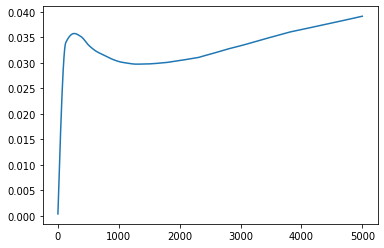

In [19]:
tmp = [curva_libor.zeroRate(y, ql.Simple, ql.Annual).rate() for y in STEPS]
plt.plot(tmp)

#### Curva USD Local

In [20]:
#Curva USD Local
tasas_usd_local = np.array(data['Dólar Local'].values)
tasas_usd_local = np.insert(tasas_usd_local, 0,0)
curva_usd_local = CurvaDescuento(dates, tasas_usd_local.tolist(), ql.Actual360())

#### Curva OIS

In [21]:
#Curva USD Local
tasas_ois = data['OIS Zero'].values
tasas_ois = np.insert(tasas_ois, 0,0)
curva_ois = CurvaDescuento(dates, tasas_ois.tolist(), ql.Actual360())

#### Spread Libor-OIS

In [22]:
#Curva USD Local
LOIS = np.zeros(shape=T+1)
LOIS[1:] = curva_libor.vec_forwardRate(STEPS-DT, STEPS)- curva_ois.vec_forwardRate(STEPS-DT, STEPS)
LOIS[0] = LOIS[1]

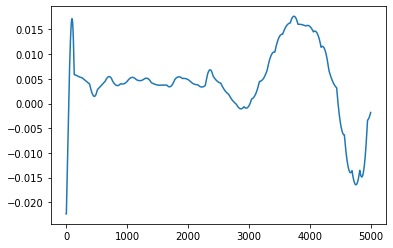

In [23]:
plt.plot(LOIS)

#### Testing Curvas

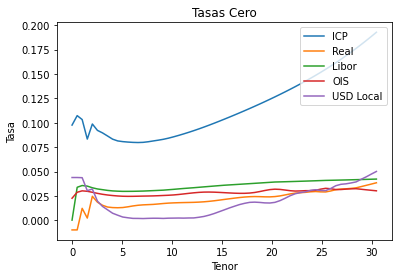

    Nominal   Real   Libor  USD Local    OIS
0    0.0000 0.0000 -0.0003    -0.0000 0.0000
1    0.0000 0.0000  0.0000     0.0000 0.0000
2    0.0000 0.0000  0.0000     0.0000 0.0000
3    0.0000 0.0000  0.0000     0.0000 0.0000
4    0.0000 0.0000  0.0000     0.0000 0.0000
..      ...    ...     ...        ...    ...
56  -0.0000 0.0000  0.0000     0.0000 0.0000
57  -0.0000 0.0000  0.0000     0.0000 0.0000
58  -0.0000 0.0000  0.0000     0.0000 0.0000
59  -0.0000 0.0000  0.0000     0.0000 0.0000
60  -0.0000 0.0000  0.0000     0.0000 0.0000

[61 rows x 5 columns]


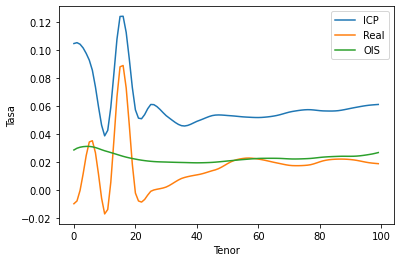

In [24]:
#Output QL
tasas_nominal_ql = [curva_nominal.zeroRate(y, ql.Simple, ql.Annual).rate() for y in year_fractions]
tasas_real_ql = [curva_real.zeroRate(y, ql.Simple, ql.Annual).rate() for y in year_fractions]
tasas_libor_ql = [curva_libor.zeroRate(y, ql.Simple, ql.Annual).rate() for y in year_fractions]
tasas_usd_local_ql = [curva_usd_local.zeroRate(y, ql.Simple, ql.Annual).rate() for y in year_fractions]
tasas_ois_ql = [curva_ois.zeroRate(y, ql.Simple, ql.Annual).rate() for y in year_fractions]

#Plots
plt.plot(year_fractions, tasas_nominal_ql, label='ICP')
plt.plot(year_fractions, tasas_real_ql, label='Real')
plt.plot(year_fractions, tasas_libor_ql, label='Libor')
plt.plot(year_fractions, tasas_ois_ql, label='OIS')
plt.plot(year_fractions, tasas_usd_local_ql, label='USD Local')

plt.title('Tasas Cero')
plt.legend(loc='upper right')
plt.ylabel('Tasa')
plt.xlabel('Tenor')
plt.show()

print(pd.DataFrame({'Nominal':tasas_nominal[1:]-tasas_nominal_ql,
 'Real':tasas_real[1:]-tasas_real_ql,
 'Libor':tasas_libor-tasas_libor_ql,
 'USD Local':tasas_usd_local[1:]-tasas_usd_local_ql,
 'OIS':tasas_ois[1:]-tasas_ois_ql}))

#Curva Forward
t = np.arange(0.5,10.5,0.1)
forward_nominal = curva_nominal.vec_forwardRate(t-0.5,t)
forward_real = curva_real.vec_forwardRate(t-0.5,t)
forward_ois = curva_ois.vec_forwardRate(t-0.5,t)
plt.plot(forward_nominal, label='ICP')
plt.plot(forward_real, label='Real')
plt.plot(forward_ois, label='OIS')
plt.legend(loc='upper right')
plt.ylabel('Tasa')
plt.xlabel('Tenor')
plt.show()

#### Modelo

In [25]:
#Alpha
ALPHA_NOMINAL = 0.1
ALPHA_REAL = 0.1
ALPHA_LIBOR = 0.1
ALPHA_USD_LOCAL = 0.1
ALPHA_OIS = 0.1

#modelos
r0_nominal = curva_nominal.zeroRate(DT, ql.Simple).rate()
HW_nominal = HullWhite_1F(DT, ALPHA_NOMINAL, SIGMA_NOMINAL, curva_nominal, r0_nominal)

r0_real = curva_real.zeroRate(DT, ql.Simple).rate()
HW_real = HullWhite_1F(DT, ALPHA_REAL,SIGMA_REAL, curva_real, r0_real)

#pendiente: cambiar sigma de ois
r0_ois = curva_ois.zeroRate(DT, ql.Simple).rate()
HW_ois = HullWhite_1F(DT, ALPHA_OIS, SIGMA_LIBOR, curva_ois, r0_ois)

r0_libor = curva_libor.zeroRate(DT, ql.Simple).rate()

print(r0_nominal*100, r0_real*100, r0_ois*100, r0_libor*100)

9.76875578266867 -0.9752964828413369 2.272838395628307 0.03795370950854249


#### Thetas

In [26]:
theta_nominal = HW_nominal.theta(STEPS)
theta_real = HW_real.theta(STEPS)
theta_ois = HW_ois.theta(STEPS)

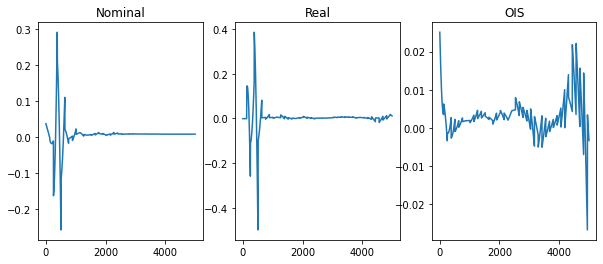

In [27]:
plt.figure(figsize=(10,4))
plt.subplot(1,3,1)
plt.title('Nominal')
plt.plot(theta_nominal)
plt.subplot(1,3,2)
plt.title('Real')
plt.plot(theta_real)
plt.subplot(1,3,3)
plt.title('OIS')
plt.plot(theta_ois)
plt.show()

#### Fit Tasas Cero

In [28]:
t = np.arange(0.5,10.5,0.5)

HW_zeros_nominal = (1/HW_nominal.zero_cupon(0,t,r0_nominal)-1)/t
tasas_nominal = [curva_nominal.zeroRate(y, ql.Simple, ql.Annual).rate() for y in t]

HW_zeros_real = (1/HW_real.zero_cupon(0,t,r0_real)-1)/t
tasas_real = [curva_real.zeroRate(y, ql.Simple, ql.Annual).rate() for y in t]

HW_zeros_ois = (1/HW_ois.zero_cupon(0,t,r0_ois)-1)/t
tasas_ois = [curva_ois.zeroRate(y, ql.Simple, ql.Annual).rate() for y in t]

pd.DataFrame({'Nominal':tasas_nominal - HW_zeros_nominal,
 'Real':tasas_real - HW_zeros_real,
 'OIS':tasas_ois - HW_zeros_ois}).head(20)

,Nominal,Real,OIS
0,-0.0000,-0.0000,-0.0000
1,-0.0000,-0.0000,-0.0000
2,-0.0000,-0.0000,-0.0000
3,-0.0000,-0.0000,-0.0000
4,-0.0000,-0.0000,-0.0000
5,-0.0000,-0.0000,-0.0000
6,-0.0000,-0.0000,-0.0000
7,-0.0000,-0.0000,-0.0000
8,-0.0000,-0.0000,-0.0000
9,-0.0000,-0.0000,-0.0000


#### Monte Carlo

In [29]:
#Inicializacion matrices
n = np.zeros(shape=(T+1, W.shape[1]))
dn = np.zeros(shape=(T, W.shape[1]))
#real
r = np.zeros(shape=(T+1, W.shape[1]))
dr = np.zeros(shape=(T, W.shape[1]))
#infla
i = np.zeros(shape=(T+1, W.shape[1]))
di = np.zeros(shape=(T, W.shape[1]))
#ois (como L)
ois = np.zeros(shape=(T+1, W.shape[1]))
dois = np.zeros(shape=(T, W.shape[1]))
#tc
tc = np.zeros(shape=(T+1, W.shape[1]))
dtc = np.zeros(shape=(T, W.shape[1]))

In [30]:
#Condiciones iniciales
n[0] = r0_nominal
r[0] = r0_real
ois[0] = r0_ois
tc[0] = USD_HOY
i[0] = UF_HOY

In [31]:
def get_index(name, matrix):
    for i, n in enumerate(matrix.columns):
        if n==name:
            return i
    return None
get_index('ois',COV_MATRIX)

1

In [32]:
#Variables aleatorias
dw_nominal = W[:,:,get_index('icp',COV_MATRIX)]
dw_real = W[:,:,get_index('real',COV_MATRIX)]
dw_inflacion = W[:,:,get_index('inflation',COV_MATRIX)]
dw_tc = W[:,:,get_index('tc_log_r',COV_MATRIX)]
dw_ois = W[:,:,get_index('ois',COV_MATRIX)]

In [33]:
#Precomputo
sqrt_dt = np.sqrt(DT)

dw_nominal =  dw_nominal*SIGMA_NOMINAL*sqrt_dt
dw_real =  dw_real*SIGMA_REAL*sqrt_dt
dw_inflacion =  dw_inflacion*SIGMA_INFLACION*sqrt_dt
dw_tc = dw_tc*SIGMA_TC*sqrt_dt
dw_ois =  dw_ois*SIGMA_LIBOR*sqrt_dt

In [34]:
#arreglar OIS y Libor
for day in range(T):
    #ois
    dois[day,:] = (theta_ois[day]-ALPHA_OIS*ois[day,:]-COV_MATRIX.at['ois','tc_log_r']/100)*DT+dw_ois[day,:]
    ois[day+1,:] = ois[day,:]+dois[day,:]
    
    #icp
    dn[day,:] = (theta_nominal[day]-ALPHA_NOMINAL*n[day,:])*DT+dw_nominal[day,:]
    n[day+1,:] = n[day,:]+dn[day,:]    
    
    #tc
    dtc[day,:] = tc[day,:]*((n[day,:]-ois[day,:])*DT+dw_tc[day,:])
    tc[day+1,:] = tc[day,:]+dtc[day,:]
    
    #real
    dr[day,:] = (theta_real[day]-ALPHA_REAL*r[day,:]-COV_MATRIX.at['real','inflation']/100)*DT+dw_real[day,:]
    r[day+1,:] = r[day,:]+dr[day,:]    
    
    #infla
    di[day,:] = i[day,:]*(n[day,:]-r[day,:])*DT+i[day,:]*dw_inflacion[day,:]
    i[day+1,:] = i[day,:]+di[day,:]


### Libor

In [35]:
l = ois+LOIS.reshape(-1,1)
HW_libor = HW_ois
HW_libor.curve = curva_libor

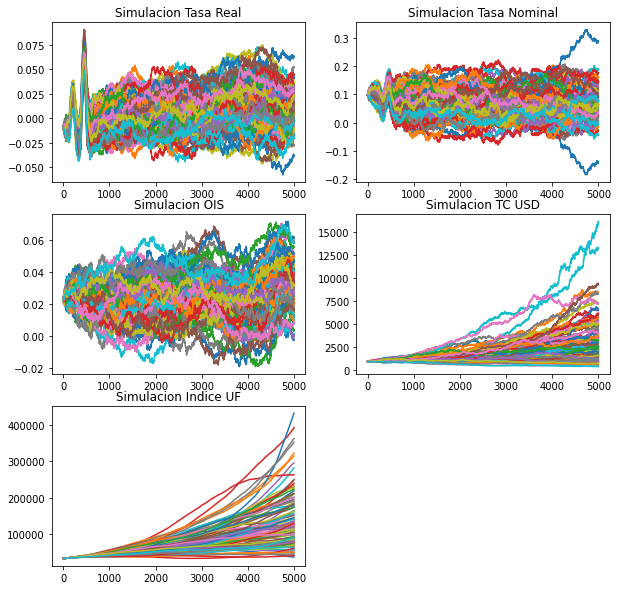

In [36]:
plt.figure(figsize=(10, 10))
plt.subplot(3,2,1)
plt.plot(r[:,0:100])
plt.title('Simulacion Tasa Real')

plt.subplot(3,2,2)
plt.plot(n[:,0:100])
plt.title('Simulacion Tasa Nominal')

plt.subplot(3,2,3)
plt.plot(ois[:,0:100])
plt.title('Simulacion OIS')

plt.subplot(3,2,4)
plt.plot(tc[:,0:100])
plt.title('Simulacion TC USD')

plt.subplot(3,2,5)
plt.plot(i[:,0:100])
plt.title('Simulacion Indice UF')
plt.savefig('simulaciones_curvas')
plt.show()

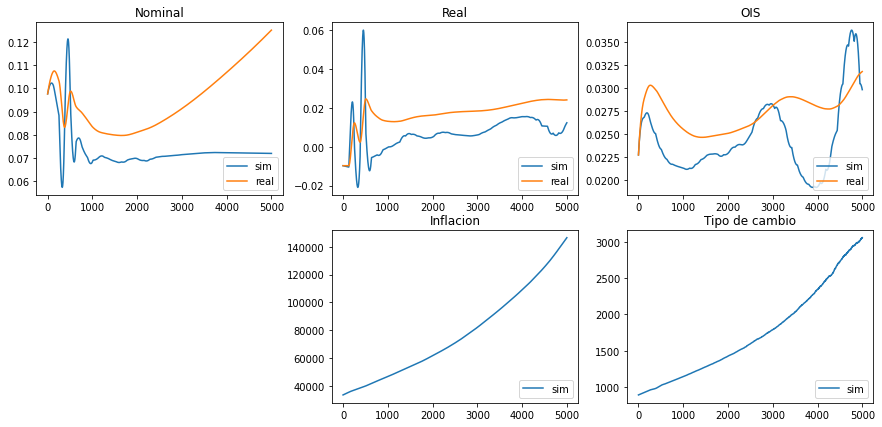

In [37]:
#PROMEDIOS
avg_nominal = n.mean(axis=1)
avg_real = r.mean(axis=1)
avg_ois = ois.mean(axis=1)
avg_tc = tc.mean(axis=1)
avg_i = i.mean(axis=1)

t = np.arange(1,avg_nominal.shape[0],1)

tasas_nominal = [curva_nominal.zeroRate(y/250, ql.Simple, ql.Annual).rate() for y in t]
tasas_real = [curva_real.zeroRate(y/250, ql.Simple, ql.Annual).rate() for y in t]
tasas_ois = [curva_ois.zeroRate(y/250, ql.Simple, ql.Annual).rate() for y in t]

plt.figure(figsize=(15,7))
plt.subplot(2,3,1)
plt.title('Nominal')
plt.plot(avg_nominal,label='sim')
plt.plot(tasas_nominal,label='real')
plt.legend(loc='lower right')

plt.subplot(2,3,2)
plt.title('Real')
plt.plot(avg_real,label='sim')
plt.plot(tasas_real,label='real')
plt.legend(loc='lower right')


plt.subplot(2,3,3)
plt.title('OIS')
plt.plot(avg_ois,label='sim')
plt.plot(tasas_ois,label='real')
plt.legend(loc='lower right')

plt.subplot(2,3,5)
plt.title('Inflacion')
plt.plot(avg_i,label='sim')
plt.legend(loc='lower right')

plt.subplot(2,3,6)
plt.title('Tipo de cambio')
plt.plot(avg_tc,label='sim')
plt.legend(loc='lower right')
plt.show()

#### Monte Carlo Convergence

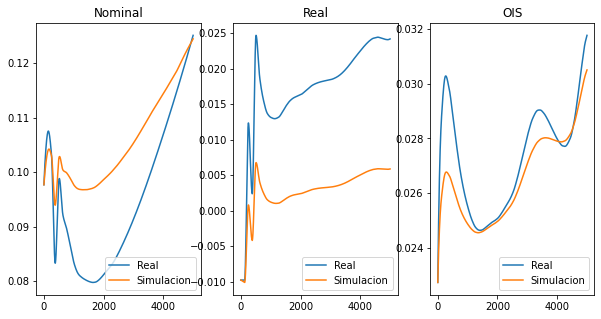

In [38]:
avg_descuento_nominal = np.mean(np.cumprod(np.exp(-n*DT),axis=0),axis=1)
avg_nominal = ((1/avg_descuento_nominal[:-1]-1)/STEPS)

avg_descuento_real = np.mean(np.cumprod(np.exp(-r*DT),axis=0),axis=1)
avg_real = ((1/avg_descuento_real[:-1]-1)/STEPS)

avg_descuento_ois = np.mean(np.cumprod(np.exp(-ois*DT),axis=0),axis=1)
avg_ois = ((1/avg_descuento_ois[:-1]-1)/STEPS)

plt.figure(figsize=(10,5))
plt.subplot(1,3,1)
plt.plot(tasas_nominal, label='Real')
plt.plot(avg_nominal, label='Simulacion')
plt.legend(loc='lower right')
plt.title('Nominal')

plt.subplot(1,3,2)
plt.plot(tasas_real, label='Real')
plt.plot(avg_real, label='Simulacion')
plt.legend(loc='lower right')
plt.title('Real')

plt.subplot(1,3,3)
plt.plot(tasas_ois, label='Real')
plt.plot(avg_ois, label='Simulacion')
plt.legend(loc='lower right')
plt.title('OIS')

plt.show()

<h3>MTM SWAPs</h3>

In [39]:
clp_models = [HW_nominal, HW_real]
clp_r0 = [r0_nominal,r0_real]

years = np.arange(2,30,2)
irs_tasas = []
cross_tasas = []
for y in years:
    side = 0
    swap = IRS(y,clp_models[0], n=1, side=side)
    swap.set_eval_date(0)
    irs_tasas.append(swap.get_rate(r0_nominal, set_rate=True)*100)
    cross = CrossUFICP(y,clp_models,UF_HOY,n=1/UF_HOY, side=side)
    cross.set_eval_date(0)
    cross_tasas.append(cross.get_rate(clp_r0,UF_HOY,swap.fixed_rate,set_rate=True)*100)

pd.DataFrame({'ICP':irs_tasas,'UF':cross_tasas},index=years)

,ICP,UF
2,9.2435,5.4977
4,7.5265,2.0193
6,6.8579,1.9415
8,6.5734,1.9619
10,6.4618,1.9972
12,6.4408,1.9704
14,6.4460,2.0114
16,6.4560,2.1323
18,6.4609,2.1957
20,6.4622,2.1440


In [40]:
clp_r0 = [r0_nominal,r0_real]
basis_r0 = [r0_nominal, r0_libor, r0_libor]
cross_libor_r0 = [r0_nominal,r0_real,r0_libor,r0_libor]


years=[2,5,10,20]
results = {}
results_EFV = {}
clp_models = [HW_nominal,HW_real]
basis_models = [HW_nominal,HW_libor,HW_libor]
cross_libor_models = [HW_nominal, HW_real, HW_libor, HW_libor]
side = 1
for y in years:
    swap = IRS(y,clp_models[0], n=1, side=side)
    cross = CrossUFICP(y,clp_models,UF_HOY,n=1/UF_HOY, side=side)
    basis = Basis(y,models=basis_models,spot=USD_HOY,n=1/USD_HOY,side=side)
    cross_libor = CrossUFUSD(y,models=cross_libor_models,spots=[UF_HOY,USD_HOY],n=1/UF_HOY,side=side)

    swap.set_eval_date(0)
    cross.set_eval_date(0)
    basis.set_eval_date(0)
    cross_libor.set_eval_date(0)
    
    swap.get_rate(r0_nominal, set_rate=True)
    cross.get_rate(clp_r0,UF_HOY,swap.fixed_rate,set_rate=True)
    basis.get_spread(basis_r0,USD_HOY,set_rate=True)
    cross_libor.get_rate(cross_libor_r0,spots=[UF_HOY,USD_HOY],set_rate=True)
    
    
    irs_mtm = np.zeros(shape=(DIAS_POR_ANO*y+1,W.shape[1]))
    cross_mtm = np.zeros(shape=(DIAS_POR_ANO*y+1,W.shape[1]))
    basis_mtm = np.zeros(shape=(DIAS_POR_ANO*y+1,W.shape[1]))
    cross_libor_mtm = np.zeros(shape=(DIAS_POR_ANO*y+1,W.shape[1]))
    
    irs_EFV = np.zeros(shape=(DIAS_POR_ANO*y+1,W.shape[1]))
    cross_EFV = np.zeros(shape=(DIAS_POR_ANO*y+1,W.shape[1]))
    basis_EFV = np.zeros(shape=(DIAS_POR_ANO*y+1,W.shape[1]))
    cross_libor_EFV = np.zeros(shape=(DIAS_POR_ANO*y+1,W.shape[1]))
    
    for x in range(DIAS_POR_ANO*y):
        t = x*DT
        swap.set_eval_date(t)
        cross.set_eval_date(t)
        basis.set_eval_date(t)
        cross_libor.set_eval_date(t)
        
        if x==0:
            discount=1
        else:    
            discount = np.exp(n[0:x,:].mean(axis=0)*-t)

        eval_r_clp = [n[x,:],r[x,:]]
        uf = i[x,:]
        irs_mtm[x,:] = swap.get_mtm(eval_r_clp[0])
        cross_mtm[x,:] = cross.get_mtm(eval_r_clp,uf)
        
        irs_EFV[x,:] = discount*irs_mtm[x,:]
        cross_EFV[x,:] = discount*cross_mtm[x,:]

        eval_r_usd = [n[x,:],l[x,:],l[x,:]]
        spot_usd = tc[x,:]
        basis_mtm[x,:] = basis.get_mtm(eval_r_usd,spot_usd)
                                                
        basis_EFV[x,:] = discount*basis_mtm[x,:]
        
        eval_r_cross_libor = [n[x,:],r[x,:],l[x,:],l[x,:]]
        spots = [i[x,:],tc[x,:]]
        cross_libor_mtm[x,:] = cross_libor.get_mtm(eval_r_cross_libor,spots)
        cross_libor_EFV[x,:] = discount*cross_libor_mtm[x,:]
        
    results[y] = {'IRS_MTM':irs_mtm,'CROSS_MTM':cross_mtm,'BASIS_MTM':basis_mtm,'CROSS_LIBOR_MTM':cross_libor_mtm}
    results_EFV[y] = {'IRS_EFV':irs_EFV,'CROSS_EFV':cross_EFV,'BASIS_EFV':basis_EFV,'CROSS_LIBOR_EFV':cross_libor_EFV}

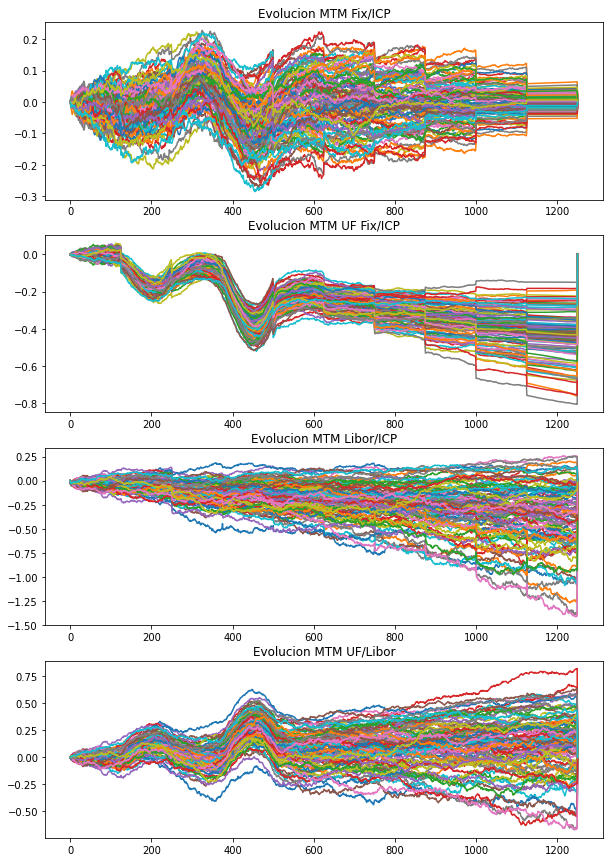

In [41]:
plt.figure(1,figsize=(10, 15))
plt.subplot(4,1,1)
plt.plot(results[5]['IRS_MTM'])
plt.title('Evolucion MTM Fix/ICP')
plt.subplot(4,1,2)
plt.plot(results[5]['CROSS_MTM'])
plt.title('Evolucion MTM UF Fix/ICP')
plt.subplot(4,1,3)
plt.plot(results[5]['BASIS_MTM'])
plt.title('Evolucion MTM Libor/ICP')
plt.subplot(4,1,4)
plt.plot(results[5]['CROSS_LIBOR_MTM'])
plt.title('Evolucion MTM UF/Libor')
plt.savefig('simulaciones_mtm')
plt.show()

<h2>E[MTM]</h2>

In [42]:
#divide
mtm_pos = {}
mtm_neg = {}
for k,mtms in results.items():
    pos = {}
    neg = {}
    for w,mtm in mtms.items():
        tmp = mtm.copy()
        tmp[tmp<0] = 0
        pos[w] = tmp.mean(axis=1)

        tmp = mtm.copy()
        tmp[tmp>0] = 0
        neg[w] = tmp.mean(axis=1)
    mtm_pos[k] = pos
    mtm_neg[k] = neg

In [43]:
#divide
EFV_pos = {}
EFV_neg = {}
for k,mtms in results_EFV.items():
    pos = {}
    neg = {}
    for w,mtm in mtms.items():
        tmp = mtm.copy()
        tmp[tmp<0] = 0
        pos[w] = tmp.mean(axis=1)

        tmp = mtm.copy()
        tmp[tmp>0] = 0
        neg[w] = tmp.mean(axis=1)
    EFV_pos[k] = pos
    EFV_neg[k] = neg

In [45]:
mtm_pos[eval_y==10]

NameError: name 'eval_y' is not defined

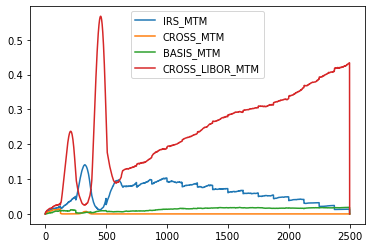

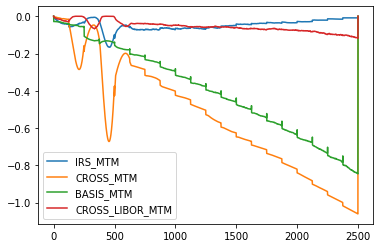

In [46]:
eval_y = 10
pd.DataFrame(mtm_pos[eval_y]).plot()
pd.DataFrame(mtm_neg[eval_y]).plot()
plt.show()

<p>Plots</p>

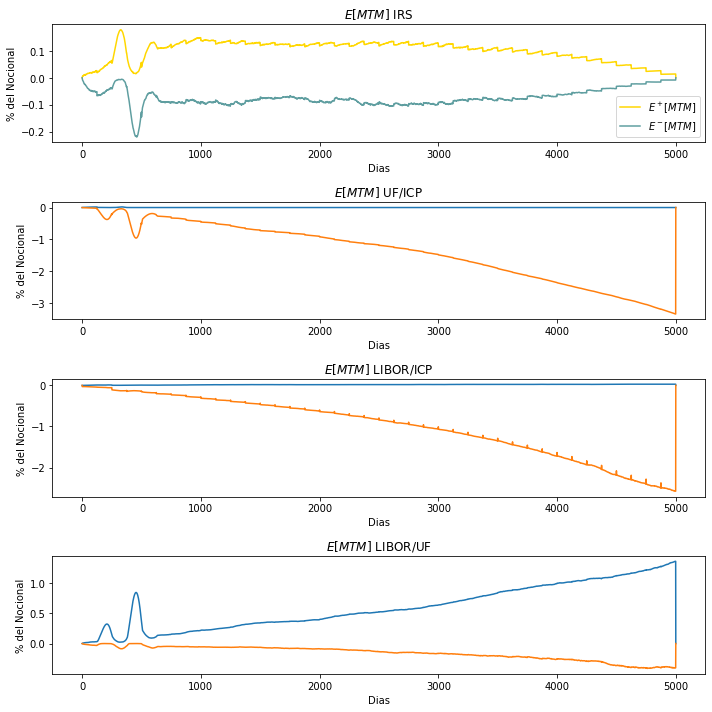

In [47]:
eval_y = 20

plt.figure(0,figsize=(10, 10))
plt.subplot(4,1,1)
plt.plot(mtm_pos[eval_y]['IRS_MTM'], color='gold', label='$E^+[MTM]$')
plt.plot(mtm_neg[eval_y]['IRS_MTM'], color='cadetblue' ,label='$E^-[MTM]$')

#Threshold
#plt.plot(thres_pos, color='gold', label='Garantias Recibidas')
#plt.plot(thres_neg, color='cadetblue', label='Garantias Constituidas')
#plt.fill_between(range(thres_pos.shape[0]),thres_pos, color='gold')
#plt.fill_between(range(thres_neg.shape[0]),thres_neg, color='cadetblue')

plt.legend(loc='lower right')
plt.title(r'$E[MTM]$ IRS')
plt.ylabel('% del Nocional')
plt.xlabel('Dias')

plt.subplot(4,1,2)
plt.plot(mtm_pos[eval_y]['CROSS_MTM'], label='$E^+[MTM]$')
plt.plot(mtm_neg[eval_y]['CROSS_MTM'], label='$E^-[MTM]$')
plt.title(r'$E[MTM]$ UF/ICP')
plt.ylabel('% del Nocional')
plt.xlabel('Dias')
plt.tight_layout()

plt.subplot(4,1,3)
plt.plot(mtm_pos[eval_y]['BASIS_MTM'], label='$E^+[MTM]$')
plt.plot(mtm_neg[eval_y]['BASIS_MTM'], label='$E^-[MTM]$')
plt.title(r'$E[MTM]$ LIBOR/ICP')
plt.ylabel('% del Nocional')
plt.xlabel('Dias')
plt.tight_layout()

plt.subplot(4,1,4)
plt.plot(mtm_pos[eval_y]['CROSS_LIBOR_MTM'], label='$E^+[MTM]$')
plt.plot(mtm_neg[eval_y]['CROSS_LIBOR_MTM'], label='$E^-[MTM]$')
plt.title(r'$E[MTM]$ LIBOR/UF')
plt.ylabel('% del Nocional')
plt.xlabel('Dias')
plt.tight_layout()
plt.savefig('e_mtm.png')
plt.show()

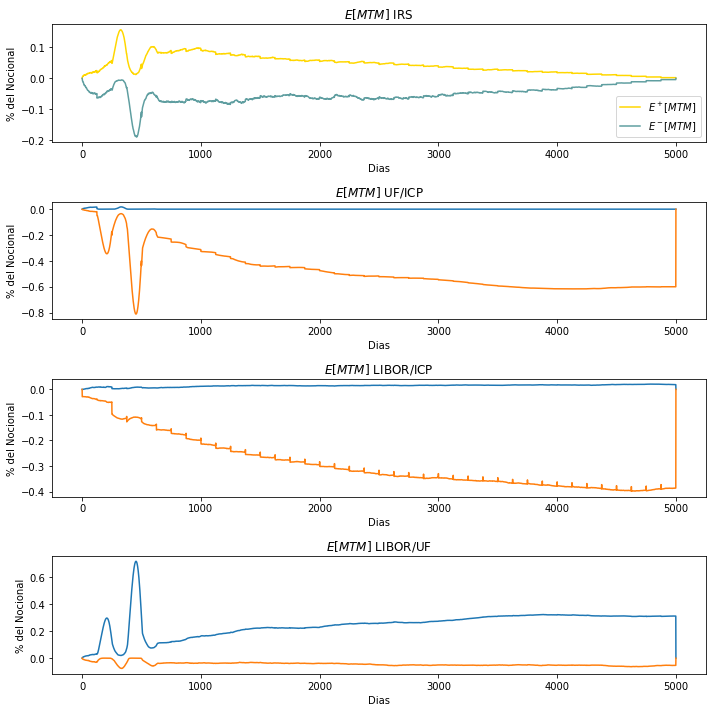

In [48]:
eval_y = 20

plt.figure(0,figsize=(10, 10))
plt.subplot(4,1,1)
plt.plot(EFV_pos[eval_y]['IRS_EFV'], color='gold', label='$E^+[MTM]$')
plt.plot(EFV_neg[eval_y]['IRS_EFV'], color='cadetblue' ,label='$E^-[MTM]$')

#Threshold
#plt.plot(thres_pos, color='gold', label='Garantias Recibidas')
#plt.plot(thres_neg, color='cadetblue', label='Garantias Constituidas')
#plt.fill_between(range(thres_pos.shape[0]),thres_pos, color='gold')
#plt.fill_between(range(thres_neg.shape[0]),thres_neg, color='cadetblue')

plt.legend(loc='lower right')
plt.title(r'$E[MTM]$ IRS')
plt.ylabel('% del Nocional')
plt.xlabel('Dias')

plt.subplot(4,1,2)
plt.plot(EFV_pos[eval_y]['CROSS_EFV'], label='$E^+[MTM]$')
plt.plot(EFV_neg[eval_y]['CROSS_EFV'], label='$E^-[MTM]$')
plt.title(r'$E[MTM]$ UF/ICP')
plt.ylabel('% del Nocional')
plt.xlabel('Dias')
plt.tight_layout()

plt.subplot(4,1,3)
plt.plot(EFV_pos[eval_y]['BASIS_EFV'], label='$E^+[MTM]$')
plt.plot(EFV_neg[eval_y]['BASIS_EFV'], label='$E^-[MTM]$')
plt.title(r'$E[MTM]$ LIBOR/ICP')
plt.ylabel('% del Nocional')
plt.xlabel('Dias')
plt.tight_layout()

plt.subplot(4,1,4)
plt.plot(EFV_pos[eval_y]['CROSS_LIBOR_EFV'], label='$E^+[MTM]$')
plt.plot(EFV_neg[eval_y]['CROSS_LIBOR_EFV'], label='$E^-[MTM]$')
plt.title(r'$E[MTM]$ LIBOR/UF')
plt.ylabel('% del Nocional')
plt.xlabel('Dias')
plt.tight_layout()
plt.savefig('e_mtm.png')
plt.show()

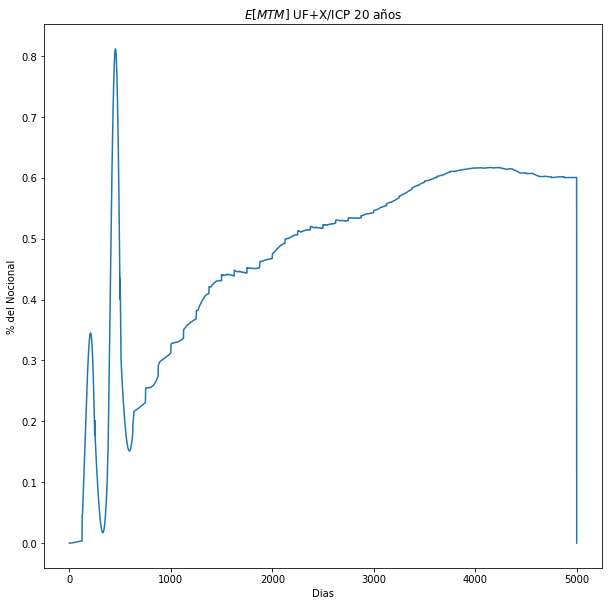

In [49]:
plt.figure(0,figsize=(10, 10))
plt.plot(-EFV_pos[eval_y]['CROSS_EFV']-EFV_neg[eval_y]['CROSS_EFV'])
plt.title(r'$E[MTM]$ UF+X/ICP 20 años')
plt.ylabel('% del Nocional')
plt.xlabel('Dias')
plt.savefig('cross_mtm.png')
plt.show()

In [50]:
#Export
export = False
if export == True:
    tmp = pd.DataFrame(mtm_pos[2])
    xw.sheets['mtm'].range('k2').options(index=False).value = tmp
    tmp = pd.DataFrame(mtm_neg[2])
    xw.sheets['mtm'].range('o2').options(index=False).value = tmp
    
    tmp = pd.DataFrame(mtm_pos[5])
    xw.sheets['mtm'].range('s2').options(index=False).value = tmp
    tmp = pd.DataFrame(mtm_neg[5])
    xw.sheets['mtm'].range('w2').options(index=False).value = tmp
        
    tmp = pd.DataFrame(mtm_pos[10])
    xw.sheets['mtm'].range('aa2').options(index=False).value = tmp
    tmp = pd.DataFrame(mtm_neg[10])
    xw.sheets['mtm'].range('ae2').options(index=False).value = tmp
    
    tmp = pd.DataFrame(mtm_pos[20])
    xw.sheets['mtm'].range('ai2').options(index=False).value = tmp
    tmp = pd.DataFrame(mtm_neg[20])
    xw.sheets['mtm'].range('am2').options(index=False).value = tmp

<h2>Perfil Capital</h2>

In [52]:
#Casos: Cash, Centrales o Nada
# APR 100%
apr = 1
k = {}
for y,mtms in results.items():
    k_cash, k_central,k_nada  = {}, {}, {}
    for prod,mtm in mtms.items():
        T = mtm.shape[0]
        cash = np.zeros_like(mtm)                
        central = np.zeros_like(mtm)                
        nada = np.zeros_like(mtm)                
        ##Colateral Cash
        if prod != 'BASIS_MTM' and prod !='CROSS_LIBOR_MTM':
            tmp = mtm[T-(DIAS_POR_ANO+1):T,:]
            cash[T-(DIAS_POR_ANO+1):T,:] = np.where(tmp>0,0,-apr*tmp)
            central[T-(DIAS_POR_ANO+1):T,:] = np.where(tmp>0,0,0)            
            nada[T-(DIAS_POR_ANO+1):T,:] = np.where(tmp>0,apr*tmp,0)
            if y>1 and y<=5:    
                tmp = mtm[0:T-(DIAS_POR_ANO+1),:]
                cash[0:T-(DIAS_POR_ANO+1)] = np.where(tmp>0,0.5/100,-apr*tmp+0.5/100*0.4)
                central[0:T-(DIAS_POR_ANO+1)] = np.where(tmp>0,0.5/100, 0.5/100*0.4)            
                nada[0:T-(DIAS_POR_ANO+1)] = np.where(tmp>0,apr*tmp+0.5/100, 0.5/100*0.4)            
            elif y>5:  
                tmp = mtm[T-(DIAS_POR_ANO*5+1):T-(DIAS_POR_ANO+1),:]
                cash[T-(DIAS_POR_ANO*5+1):T-(DIAS_POR_ANO+1),:] = np.where(tmp>0,0.5/100,-apr*tmp+0.5/100*0.4)    
                central[T-(DIAS_POR_ANO*5+1):T-(DIAS_POR_ANO+1),:] = np.where(tmp>0,0.5/100,0.5/100*0.4)    
                nada[T-(DIAS_POR_ANO*5+1):T-(DIAS_POR_ANO+1),:] = np.where(tmp>0,apr*tmp+0.5/100,0.5/100*0.4)    
                
                tmp = mtm[0:T-(DIAS_POR_ANO*5+1)]
                cash[0:T-(DIAS_POR_ANO*5+1),:] = np.where(tmp>0,1.5/100,-apr*tmp+0.015*0.4)    
                central[0:T-(DIAS_POR_ANO*5+1),:] = np.where(tmp>0,0.015,0.015*0.4)    
                nada[0:T-(DIAS_POR_ANO*5+1),:] = np.where(tmp>0,apr*tmp+1.5/100,0.015*0.4)    
        else:
            tmp = mtm[T-(DIAS_POR_ANO+1):T,:]
            cash[T-(DIAS_POR_ANO+1):T,:] = np.where(tmp>0,0.015,-apr*tmp+0.015*0.4)
            central[T-(DIAS_POR_ANO+1):T,:] = np.where(tmp>0,0.015,0.015*0.4)
            nada[T-(DIAS_POR_ANO+1):T,:] = np.where(tmp>0,apr*tmp+0.015,0.015*0.4)
            if y>1 and y<=5:
                tmp = mtm[0:T-(DIAS_POR_ANO+1),:]
                cash[0:T-(DIAS_POR_ANO+1)] = np.where(tmp>0,0.07,-apr*tmp+0.07*0.4)            
                central[0:T-(DIAS_POR_ANO+1)] = np.where(tmp>0,0.07,0.07*0.4)            
                nada[0:T-(DIAS_POR_ANO+1)] = np.where(tmp>0,apr*tmp+0.07,0.07*0.4)            
            elif y>5:  
                tmp = mtm[T-(DIAS_POR_ANO*5+1):T-(DIAS_POR_ANO+1),:]                
                cash[T-(DIAS_POR_ANO*5+1):T-(DIAS_POR_ANO+1),:] = np.where(tmp>0,0.07,-apr*tmp+0.07*0.4)    
                central[T-(DIAS_POR_ANO*5+1):T-(DIAS_POR_ANO+1),:] = np.where(tmp>0,0.07,0.07*0.4)    
                nada[T-(DIAS_POR_ANO*5+1):T-(DIAS_POR_ANO+1),:] = np.where(tmp>0,apr*tmp+0.07,0.07*0.4)    
                
                tmp = mtm[0:T-(DIAS_POR_ANO*5+1)]
                cash[0:T-(DIAS_POR_ANO*5+1),:] = np.where(tmp>0,0.13,-apr*tmp+0.13*0.4)    
                central[0:T-(DIAS_POR_ANO*5+1),:] = np.where(tmp>0,0.13,0.13*0.4)    
                nada[0:T-(DIAS_POR_ANO*5+1),:] = np.where(tmp>0,apr*tmp+0.13,0.13*0.4)
        
        #   
        m = cash
        n = central  
        o = nada
        k_cash[prod] = np.mean(m,axis=1)
        k_central[prod] = np.mean(n,axis=1)
        k_nada[prod] = np.mean(o,axis=1)
        
    k[y] = {'cash':k_cash,'central':k_central,'nada':k_nada}

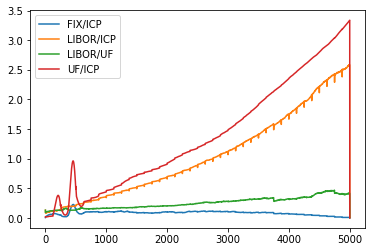

In [53]:
ejemplo = False
sim = 1
g_type = 'cash'
eval_y = 20
prod = 'IRS_MTM'
if ejemplo == True:
    plt.title('Uso de capital con Cash')
    plt.xlabel('Dias')
    plt.ylabel('MTM (%)')
    plt.plot(k[eval_y][g_type][prod][:,sim],label='capital')
    plt.plot(results[eval_y][prod][:,sim],label='mtm')
    plt.legend(loc='upper right')
    plt.savefig('k_cash.png')
    plt.show()
    
else:
    plt.plot(k[eval_y][g_type]['IRS_MTM'],label='FIX/ICP')
    plt.plot(k[eval_y][g_type]['BASIS_MTM'],label='LIBOR/ICP')
    plt.plot(k[eval_y][g_type]['CROSS_LIBOR_MTM'],label='LIBOR/UF')
    plt.plot(k[eval_y][g_type]['CROSS_MTM'],label='UF/ICP')
    plt.legend(loc='upper left')
    plt.show()
    

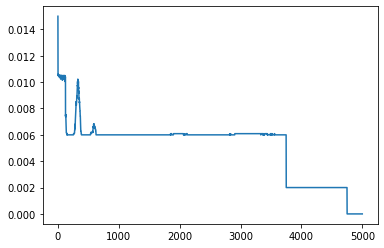

In [54]:
plt.plot(k[eval_y]['central']['CROSS_MTM'])

In [55]:
#Parametros
params = xw.sheets['params'].range('Q5:R11').options(pd.DataFrame,header=False).value
dur = xw.sheets['params'].range('T3:X7').options(pd.DataFrame).value

if side==1:
    first_row = 2
else:
    first_row = 8

AttributeError: 'NoneType' object has no attribute 'books'

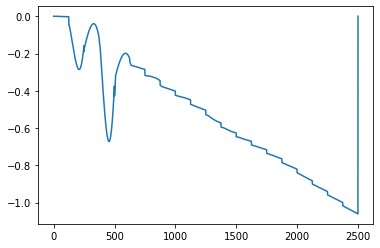

In [56]:
plt.plot(mtm_pos[10]['CROSS_MTM']+mtm_neg[10]['CROSS_MTM'])

<h3>KVA</h3>

In [57]:
if export == True:
    s_k = params.loc['Spread Capital'][0]
    i = 0
    for y in k.keys():        
        w = pd.DataFrame(columns=['IRS_MTM','CROSS_MTM','BASIS_MTM','CROSS_LIBOR_MTM'])
        for gtype in k[y].keys():                        
            tmp = pd.DataFrame(k[y][gtype])                                                
            w.loc[gtype] = (tmp.sum().values*DT*s_k*10000)/dur[y].T.values
        xw.sheets['resultados-tabla'].range((first_row,2+5*i)).value = w
        i += 1

<h3>CVA</h3>

In [58]:
if export == True:
    dP = xw.sheets['params'].range('J2:J5003').options(pd.DataFrame,index=False).value
    recovery = params.loc['Recuperacion'][0]
    w = pd.DataFrame(columns=['IRS_MTM','CROSS_MTM','BASIS_MTM','CROSS_LIBOR_MTM'])                     
    for y in mtm_pos.keys():                
        tmp = pd.DataFrame(mtm_pos[y]) 
        T = tmp.size 
        w.loc[y] = ((1-recovery)*(tmp.values.T @ dP[0:tmp.shape[0]].values)*10000).reshape(4)/dur[y].values
    xw.sheets['resultados-tabla'].range((first_row+12,2)).value = w

<h3>FVA</h3>

In [59]:
if export == True:
    spread_cf = xw.sheets['params'].range('H2:H5003').options(pd.DataFrame,index=False).value
    w = pd.DataFrame(columns=['IRS_MTM','CROSS_MTM','BASIS_MTM','CROSS_LIBOR_MTM'])                     
    for y in EFV_pos.keys():                
        tmp = pd.DataFrame(EFV_pos[y]) + pd.DataFrame(EFV_neg[y]) 
        T = tmp.size 
        w.loc[y] = ((tmp.values.T @ spread_cf[0:tmp.shape[0]].values*DT)*10000).reshape(4)/dur[y].values
    xw.sheets['resultados-tabla'].range((first_row+12,8)).value = w

if export == True:
    spread_cf = xw.sheets['params'].range('L3:L5003').options(np.array).value
    df = xw.sheets['params'].range('M3:M5003').options(np.array).value
    disct = df * spread_cf
    w = pd.DataFrame(columns=['IRS_MTM','CROSS_MTM','BASIS_MTM','CROSS_LIBOR_MTM'])                     
    for y in mtm_pos.keys():                
        tmp = pd.DataFrame(mtm_pos[y]) + pd.DataFrame(mtm_neg[y]) 
        T = tmp.size 
        w.loc[y] = ((tmp.values.T @ (disct[0:tmp.shape[0]]))).reshape(4)*10000/dur[y].values
    xw.sheets['resultados-tabla'].range((first_row+12,8)).value = w

<h3>COLVA</h3>

if export == True:
    spread_423 = xw.sheets['params'].range('E2:E5003').options(pd.DataFrame,index=False).value
    w = pd.DataFrame(columns=['IRS_MTM','CROSS_MTM','BASIS_MTM','CROSS_LIBOR_MTM'])                     
    for y in mtm_pos.keys():                
        tmp = pd.DataFrame(mtm_pos[y]) + pd.DataFrame(mtm_neg[y]) 
        T = tmp.size 
        w.loc[y] = ((tmp.values.T @ spread_423[0:tmp.shape[0]].values)*10000*DT).reshape(4)/dur[y].values
    xw.sheets['resultados-tabla'].range((first_row+12,14)).value = w

In [60]:
if export == True:
    spread_423 = xw.sheets['params'].range('E2:E5003').options(pd.DataFrame,index=False).value
    w = pd.DataFrame(columns=['IRS_MTM','CROSS_MTM','BASIS_MTM','CROSS_LIBOR_MTM'])                     
    for y in mtm_pos.keys():                
        tmp = pd.DataFrame(EFV_pos[y]) + pd.DataFrame(EFV_neg[y]) 
        w.loc[y] = ((tmp.values.T @ spread_423[0:tmp.shape[0]].values*DT)*10000).reshape(4)/dur[y].values
    xw.sheets['resultados-tabla'].range((first_row+12,14)).value = w

In [ ]:
w

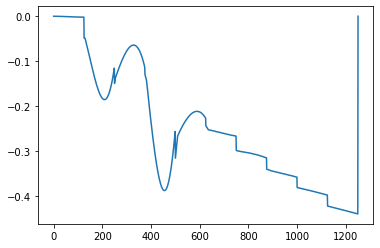

In [61]:
y = 5
tmp = pd.DataFrame(mtm_pos[y]) + pd.DataFrame(mtm_neg[y]) 
plt.plot(tmp.CROSS_MTM)